# Setup

Install required packages (only needed once per environment).  
Packages used:

- `transformers` (Hugging Face) for pretrained models and pipelines
- `torch` as backend for Transformer models
- `pandas`, `numpy` for data wrangling
- `scikit-learn` for metrics and train/test split
- `matplotlib` for plots


In [81]:
!pip install --upgrade pip
!pip install numpy pandas matplotlib scikit-learn transformers torch --extra-index-url https://download.pytorch.org/whl/cpu

Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cpu


In [82]:
import os, re, math, random, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score

from transformers import pipeline
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Path to  dataset file
DATA_PATH = "archive (5)/smile-annotations-final.csv"

print("Using data file:", DATA_PATH)

Using data file: archive (5)/smile-annotations-final.csv


# Load Data & Quick EDA

Load the SMILE dataset, show basic info, and preview a few rows to understand columns.


In [83]:
df = pd.read_csv(DATA_PATH)

print("Shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nHead:")
display(df.head(10))

Shape: (3084, 3)

Columns: ['611857364396965889', '@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap', 'nocode']

Head:


,611857364396965889,@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap,nocode
0,614484565059596288,Dorian Gray with Rainbow Scarf #LoveWins (from...,happy
1,614746522043973632,@SelectShowcase @Tate_StIves ... Replace with ...,happy
2,614877582664835073,@Sofabsports thank you for following me back. ...,happy
3,611932373039644672,@britishmuseum @TudorHistory What a beautiful ...,happy
4,611570404268883969,@NationalGallery @ThePoldarkian I have always ...,happy
5,614456889863208960,"@britishmuseum say wot, mate?",nocode
6,614016385442807809,Two workshops on evaluating audience engagemen...,nocode
7,610916556751642624,"A Forest Road, by Thomas Gainsborough 1750 Oil...",nocode
8,614499696015503361,Lucky @FitzMuseum_UK! Good luck @MirandaStearn...,happy
9,612869223354925056,"""1...2..."" ""non arrête mon brush!"". l.Alma|A f...",nocode


### Rename and adjust columns 

In [84]:

# Rename columns and drop id column
df_sent = df.rename(columns={'611857364396965889': 'id', '@aandraous @britishmuseum @AndrewsAntonio Merci pour le partage! @openwinemap': 'text', 'nocode': 'category'}) 
df_sent.drop('id', axis=1, inplace=True)

print("\nSample rows after renaming:")
display(df_sent.sample(5, random_state=RANDOM_SEED))
print("\n", df_sent.info())


Sample rows after renaming:


,text,category
1505,Year 4 @britishmuseum checking out some Ancien...,happy
2398,@DavidSmithArt @roshvarosha @LisaLooly @newman...,happy
1814,Start your @_TheWhitechapel #FirstThursday at ...,nocode
511,Project curator sought for South Africa exhibi...,not-relevant
1565,See all the photos from Wednesday's #Defeating...,nocode


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3084 entries, 0 to 3083
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   text      3084 non-null   object
 1   category  3084 non-null   object
dtypes: object(2)
memory usage: 48.3+ KB

 None


# Preprocess: Clean Text 

Clean the text (lowercase, strip URLs/mentions/hashtags).


In [85]:
URL_RE = re.compile(r"http\S+|www\.\S+")
MENTION_RE = re.compile(r"@\w+")
HASHTAG_RE = re.compile(r"#(\w+)")
MULTISPACE_RE = re.compile(r"\s+")

def clean_text(s: str) -> str:
    s = s.lower()
    s = URL_RE.sub("", s)
    s = MENTION_RE.sub("", s)
    s = HASHTAG_RE.sub(r"\1", s)  # keep hashtag word
    s = re.sub(r"[^\x00-\x7F]+", " ", s)  # drop non-ascii (quick/simple)
    s = MULTISPACE_RE.sub(" ", s).strip()
    return s

df_sent['text'] = df_sent["text"].astype(str).apply(clean_text)
df_sent


,text,category
0,dorian gray with rainbow scarf lovewins (from,happy
1,... replace with your wish which the artist us...,happy
2,thank you for following me back. great to hear...,happy
3,what a beautiful jewel / portrait. is the 'r' ...,happy
4,i have always loved this painting.,happy
...,...,...
3079,mt : looking forward to our public engagement ...,happy
3080,upper arm guard?,nocode
3081,mesmerising.,happy
3082,the 2nd genocide against biafrans as promised ...,not-relevant


# Build Two Sentiment Pipelines

Build two Hugging Face `pipeline` objects.

- Model A: `distilbert-base-uncased-finetuned-sst-2-english` (binary: POSITIVE/NEGATIVE).
- Model B: `cardiffnlp/twitter-roberta-base-sentiment-latest` (ternary: NEGATIVE/NEUTRAL/POSITIVE).  
  We will post-process so both return one of {NEGATIVE, NEUTRAL, POSITIVE}.

In [86]:
model_a = "distilbert-base-uncased-finetuned-sst-2-english"  # binary
model_b = "cardiffnlp/twitter-roberta-base-sentiment-latest" # ternary

# Set up piplines
tokenizer_a = AutoTokenizer.from_pretrained(model_a)
tokenizer_b = AutoTokenizer.from_pretrained(model_b)
clf_a = pipeline('sentiment-analysis', model=model_a, tokenizer=tokenizer_a) # returns label/score
clf_b = pipeline('sentiment-analysis', model=model_b, tokenizer=tokenizer_b)
print("piplines ready")

Device set to use cpu
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


piplines ready


# Run Individual Prediction Examples

In [192]:
# Create individual sentence predictor function
def pipe_predict(text, pipe):
    sent_list = []
    score_list = []
    for i in text['text']:
        sent_label = pipe(i)[0]['label']
        sent_score = pipe(i)[0]['score']
        sent_list.append(sent_label)
        score_list.append(sent_score)

    text['sentiment'] = sent_list
    text['score'] = score_list
    return(text) 

df_samples = df_sent.sample(5, random_state=RANDOM_SEED)

### Distilbert model sentiment labeling

In [193]:
pipe_predict(df_samples, clf_a)

,text,category,sentiment,score
1505,year 4 checking out some ancient egypt artefac...,happy,POSITIVE,0.995177
2398,thank you :-),happy,POSITIVE,0.999824
1814,start your firstthursday at ceviche old st gal...,nocode,NEGATIVE,0.978847
511,project curator sought for south africa exhibi...,not-relevant,POSITIVE,0.628066
1565,see all the photos from wednesday's defeatingd...,nocode,NEGATIVE,0.936161


### RoBERTa model sentiment labeling

In [ ]:
pipe_predict(df_samples, clf_b)

,text,category,sentiment,score
1505,year 4 checking out some ancient egypt artefac...,happy,positive,0.918723
2398,thank you :-),happy,positive,0.953553
1814,start your firstthursday at ceviche old st gal...,nocode,neutral,0.811932
511,project curator sought for south africa exhibi...,not-relevant,neutral,0.921039
1565,see all the photos from wednesday's defeatingd...,nocode,neutral,0.901342


As we can see our Hugging Face models are operational and the pipelines are producing sentiment labels as expected. As the documentation indicates, distilbert base model produced binary results of `POSITIVE` or `NEGATIVE`, while roberta has a third `NEUTRAL` label.

# Run Pipline through Dataset

In [ ]:
# Run pipeline through entire dataset
distilbert_data = pipe_predict(df_sent, clf_a)

In [ ]:
# Run pipeline through entire dataset
roberta_data = pipe_predict(df_sent, clf_b)

In [182]:
distilbert_data

,text,category,sentiment,score
0,dorian gray with rainbow scarf lovewins (from,happy,neutral,0.605416
1,... replace with your wish which the artist us...,happy,positive,0.942886
2,thank you for following me back. great to hear...,happy,positive,0.982657
3,what a beautiful jewel / portrait. is the 'r' ...,happy,positive,0.957486
4,i have always loved this painting.,happy,positive,0.973116
...,...,...,...,...
3079,mt : looking forward to our public engagement ...,happy,positive,0.910234
3080,upper arm guard?,nocode,neutral,0.914053
3081,mesmerising.,happy,positive,0.481291
3082,the 2nd genocide against biafrans as promised ...,not-relevant,negative,0.914831


In [184]:
roberta_data

,text,category,sentiment,score
0,dorian gray with rainbow scarf lovewins (from,happy,neutral,0.605416
1,... replace with your wish which the artist us...,happy,positive,0.942886
2,thank you for following me back. great to hear...,happy,positive,0.982657
3,what a beautiful jewel / portrait. is the 'r' ...,happy,positive,0.957486
4,i have always loved this painting.,happy,positive,0.973116
...,...,...,...,...
3079,mt : looking forward to our public engagement ...,happy,positive,0.910234
3080,upper arm guard?,nocode,neutral,0.914053
3081,mesmerising.,happy,positive,0.481291
3082,the 2nd genocide against biafrans as promised ...,not-relevant,negative,0.914831


# Train/Test Split

Create a stratified train/test split so the label proportions are similar across splits.  
We keep only the cleaned text and sentiment for modeling.


In [178]:
# Split distilbert data
X_distil = distilbert_data['text']
Y_distil = distilbert_data['sentiment']

X_d_train, X_d_test, Y_d_train, Y_d_test = train_test_split(
    X_distil, Y_distil, test_size=0.2, random_state=RANDOM_SEED, stratify=Y_distil
)

print("Train size:", len(X_d_train), "| Test size:", len(Y_d_test))

Train size: 2467 | Test size: 617


In [ ]:
# Split roberta data
X_rob = roberta_data['text']
Y_rob = roberta_data['sentiment']

X_r_train, X_r_test, Y__r_train, Y_r_test = train_test_split(
    X_rob, Y_rob, test_size=0.2, random_state=RANDOM_SEED, stratify=Y_rob
)

print("Train size:", len(X_r_train), "| Test size:", len(X_r_test))

Train size: 2467 | Test size: 617


# Evaluate Models

In [212]:
# Create eval function
def evaluate_model(X_test, Y_test, pipe):
    model_pred = []
    model_scores = []
    for item in X_test:
        Y_pred = pipe(item)[0]['label']
        Y_scores = pipe(item)[0]['score']
        model_pred.append(Y_pred)
        model_scores.append(Y_scores)
    acc = accuracy_score(Y_test, model_pred)
    f1m = f1_score(Y_test, model_pred, average="macro")
    print(f"Accuracy: {acc:.4f} | Macro-F1: {f1m:.4f}\n")
    print(classification_report(Y_test, model_pred, digits=4))

    # Confidence histogram
    plt.figure()
    plt.hist(model_scores, bins=20)
    plt.title(f"model — Prediction Confidence")
    plt.xlabel("confidence")
    plt.ylabel("count")
    plt.show()

    # Predicted distribution
    pd.Series(model_pred).value_counts().plot(kind="bar")
    plt.title(f"model — Predicted label distribution")
    plt.xlabel("label")
    plt.ylabel("count")
    plt.show()

### Model 'distilbert-base-uncased-finetuned-sst-2-english', eval

Accuracy: 0.0000 | Macro-F1: 0.0000

              precision    recall  f1-score   support

    NEGATIVE     0.0000    0.0000    0.0000       0.0
    POSITIVE     0.0000    0.0000    0.0000       0.0
    negative     0.0000    0.0000    0.0000      37.0
     neutral     0.0000    0.0000    0.0000     310.0
    positive     0.0000    0.0000    0.0000     270.0

    accuracy                         0.0000     617.0
   macro avg     0.0000    0.0000    0.0000     617.0
weighted avg     0.0000    0.0000    0.0000     617.0



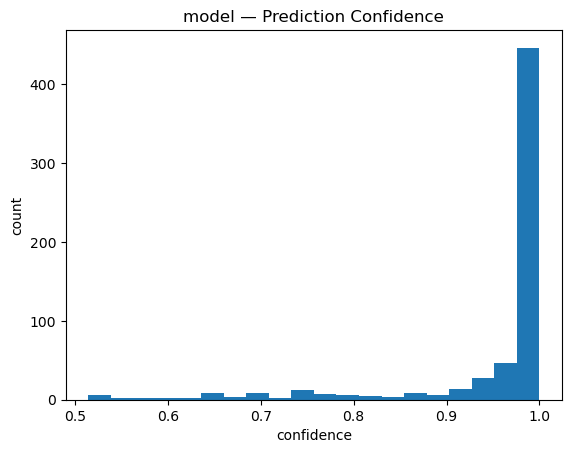

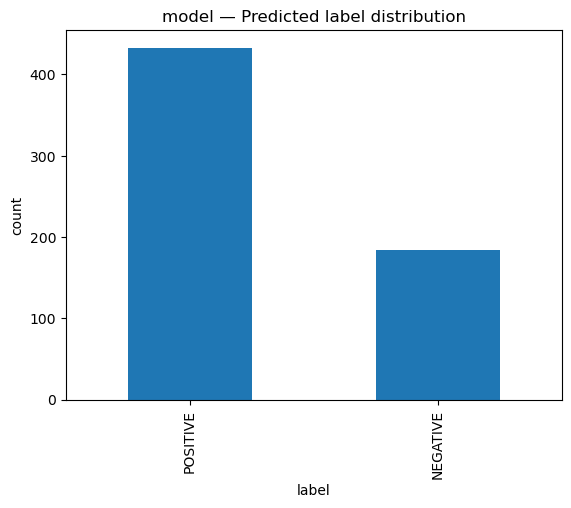

In [213]:
res_a = evaluate_model(X_d_test, Y_d_test, clf_a)
res_a

### Model 'cardiffnlp/twitter-roberta-base-sentiment-latest', eval

Accuracy: 1.0000 | Macro-F1: 1.0000

              precision    recall  f1-score   support

    negative     1.0000    1.0000    1.0000        37
     neutral     1.0000    1.0000    1.0000       310
    positive     1.0000    1.0000    1.0000       270

    accuracy                         1.0000       617
   macro avg     1.0000    1.0000    1.0000       617
weighted avg     1.0000    1.0000    1.0000       617



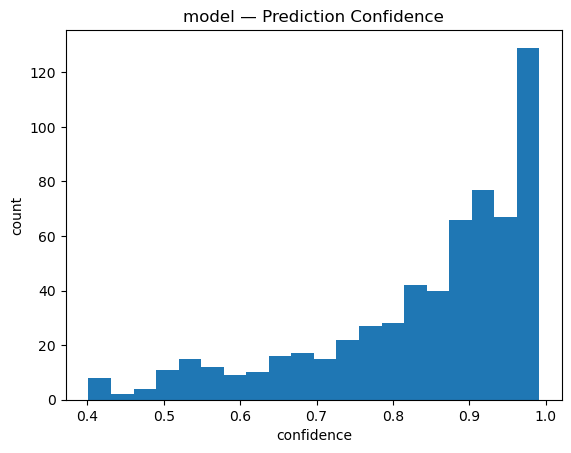

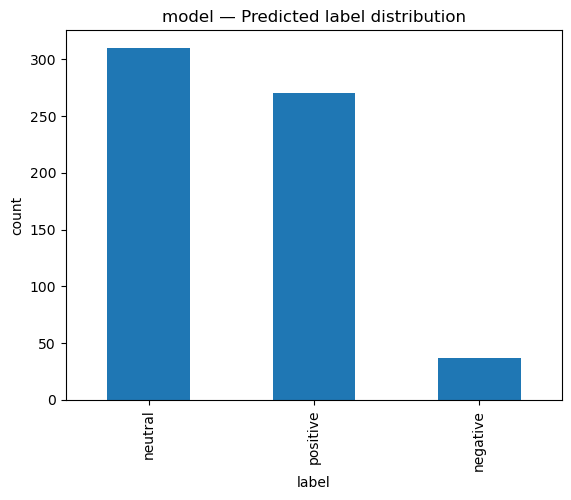

In [214]:
res_b = evaluate_model(X_r_test, Y_r_test, clf_b)
res_b

# Compare Model Metrics: Accuracy and F1 Macro

In [215]:
comp = pd.DataFrame([res_a, res_b]).sort_values("f1_macro", ascending=False).reset_index(drop=True)
print("\nComparison (higher is better):")
display(comp)

KeyError: 'f1_macro'

# Reusable Prediction Function + Simple Reasoning

**Comment for this Markdown cell:** Provide a **reusable function** to predict on **any list of texts** with either model.  
For **reasoning**: we print the model confidence and highlight whether the text contains simple **sentiment cue words** (a tiny lexicon). This is not true model explainability, but it offers an understandable rationale for beginners.


In [ ]:
POS_CUES = {"love","great","good","happy","joy","win","awesome","wonderful","amazing","like"}
NEG_CUES = {"hate","bad","sad","angry","annoyed","worry","worried","terrible","awful","disgust"}

def explain_basic(text: str):
    t = clean_text(text)
    pos_hits = sorted({w for w in POS_CUES if re.search(rf"\\b{re.escape(w)}\\b", t)})
    neg_hits = sorted({w for w in NEG_CUES if re.search(rf"\\b{re.escape(w)}\\b", t)})
    return pos_hits, neg_hits

def predict_texts(texts, model="a"):
    pipe = clf_a if str(model).lower().startswith("a") else clf_b
    preds, confs = predict_with_pipeline([clean_text(t) for t in texts], pipe)
    rows = []
    for text, label, conf in zip(texts, preds, confs):
        pos_hits, neg_hits = explain_basic(text)
        why = []
        why.append(f"model confidence={conf:.3f}")
        if pos_hits: why.append(f"positive cues: {pos_hits}")
        if neg_hits: why.append(f"negative cues: {neg_hits}")
        rows.append({"text": text, "pred": label, "confidence": conf, "why_simple": "; ".join(why)})
    return pd.DataFrame(rows)

# Demo (feel free to edit)
demo_df = predict_texts([
    "I love this new album so much!",
    "This is bad and I'm really angry about it.",
    "It's okay, nothing special."
], model="b")

display(demo_df)


# Creative Application (Your Data!)

**Comment for this Markdown cell:** Apply a chosen model to **your own domain** (e.g., song lyrics, news headlines).  
Below are two examples:

1. A **hardcoded list** (quick demo)
2. Loading from a CSV with a column called `text` (edit path/column for your file)


In [ ]:
# Example 1: hardcoded list
my_domain_texts = [
    "Breaking: Markets rally as inflation cools to 2.5%.",
    "Lyrics: I'm feeling good, like I should.",
    "Match report: The team suffers a terrible defeat."
]
creative_results = predict_texts(my_domain_texts, model="b")
display(creative_results)

# Example 2: from a CSV file you provide (uncomment and set your file path)
# custom_df = pd.read_csv("/path/to/your_data.csv")
# creative_results2 = predict_texts(custom_df["text"].astype(str).tolist(), model="b")
# display(creative_results2.head(20))

# BONUS: Fine-Tuning Template (Optional)

**Comment for this Markdown cell:** (Optional) Template for **fine-tuning** a sentiment model with Hugging Face.  
This is a **skeleton** — you must adapt it to your labels and ensure you have enough data.

> Running this section can take time and requires a GPU for best results.


In [ ]:
# # Prepare a Dataset object
# train_df = pd.DataFrame({"text": X_train, "label": pd.Categorical(y_train).codes})
# test_df  = pd.DataFrame({"text": X_test,  "label": pd.Categorical(y_test).codes})
# label_names = list(pd.Categorical(df['target']).categories)
# label2id = {name:i for i,name in enumerate(label_names)}
# id2label = {i:name for name,i in label2id.items()}

# ds_train = Dataset.from_pandas(train_df)
# ds_test  = Dataset.from_pandas(test_df)

# def tok_fn(batch):
#     return tokenizer(batch["text"], truncation=True)
# ds_train = ds_train.map(tok_fn, batched=True)
# ds_test  = ds_test.map(tok_fn, batched=True)

# collator = DataCollatorWithPadding(tokenizer=tokenizer)

# model = AutoModelForSequenceClassification.from_pretrained(
#     base_model_id, num_labels=len(label_names), id2label=id2label, label2id=label2id
# )

# args = TrainingArguments(
#     output_dir="./sentiment_ft",
#     evaluation_strategy="epoch",
#     save_strategy="epoch",
#     learning_rate=2e-5,
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=2,
#     weight_decay=0.01,
#     logging_steps=50
# )

# trainer = Trainer(
#     model=model,
#     args=args,
#     train_dataset=ds_train,
#     eval_dataset=ds_test,
#     tokenizer=tokenizer,
#     data_collator=collator,
# )

# trainer.train()
# trainer.evaluate()


# Conclusion

**What we accomplished:**

- Built a complete **sentiment analysis** workflow with two pretrained models.
- Evaluated with **accuracy, macro-F1**, and confusion matrices.
- Visualized **confidence** and **label distributions**.
- Created a reusable **prediction function** and applied it to a new domain.
- (Bonus) Prepared a **fine-tuning template** for domain adaptation.

**Next steps:**

- Collect more domain-specific labeled data and try the fine-tuning section.
- Explore more models in the Hugging Face Hub (larger RoBERTa/BERT variants).
- Add true explainability (e.g., SHAP, LIME) once you are comfortable with the basics.
